# Legal Clause Similarity â€” Complete End-to-End Pipeline

Train BiLSTM and ESIM baseline models on legal clause similarity, with all visualizations.

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import json
import os
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [72]:
# ===== TEXT PROCESSING =====
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def load_clauses_from_archive(limit_per_file=None):
    files = glob(os.path.join(ARCHIVE_DIR, '*.csv'))
    data = []
    for f in files:
        cat = os.path.splitext(os.path.basename(f))[0]
        try:
            df = pd.read_csv(f, header=None)
        except Exception as e:
            continue
        if df.shape[1] >= 1:
            col = df.iloc[:,0].astype(str)
        else:
            continue
        if limit_per_file is not None:
            col = col.iloc[:limit_per_file]
        for txt in col:
            data.append((cat, clean_text(txt)))
    return data

def clause_level_split(data, train_frac=0.7, val_frac=0.15, test_frac=0.15):
    by_cat = defaultdict(list)
    for cat, txt in data: by_cat[cat].append(txt)
    train_clauses, val_clauses, test_clauses = [], [], []
    for cat, clauses in by_cat.items():
        n = len(clauses)
        if n == 0: continue
        train_n = int(n * train_frac)
        val_n = int(n * val_frac)
        train = clauses[:train_n]
        val = clauses[train_n:train_n+val_n]
        test = clauses[train_n+val_n:]
        train_clauses.extend([(cat, c) for c in train])
        val_clauses.extend([(cat, c) for c in val])
        test_clauses.extend([(cat, c) for c in test])
    return train_clauses, val_clauses, test_clauses

def build_vocab(texts, max_vocab=60000, min_freq=1):
    cnt = Counter()
    for t in texts: cnt.update(t.split())
    tokens = [w for w,f in cnt.most_common(max_vocab) if f>=min_freq]
    stoi = {w:i+2 for i,w in enumerate(tokens)}
    stoi['<pad>']=0; stoi['<unk>']=1
    return stoi

def text_to_indices(text, stoi, max_len=80):
    toks = text.split()
    idxs = [stoi.get(t, stoi['<unk>']) for t in toks][:max_len]
    if len(idxs) < max_len: idxs += [stoi['<pad>']]*(max_len-len(idxs))
    return idxs

def generate_pairs(clauses, max_pos_per_cat=200, max_neg_pairs=20000):
    by_cat = defaultdict(list)
    for cat, txt in clauses: by_cat[cat].append(txt)
    pos_pairs = []
    for cat, texts in by_cat.items():
        n = len(texts)
        if n < 2: continue
        pairs = [(texts[i], texts[j]) for i in range(n) for j in range(i+1, n)]
        if len(pairs) > max_pos_per_cat: pairs = random.sample(pairs, max_pos_per_cat)
        pos_pairs.extend([(a,b,1) for a,b in pairs])
    all_texts = [t for _,texts in by_cat.items() for t in texts]
    neg_pairs = []
    attempts = 0
    while len(neg_pairs) < min(max_neg_pairs, len(pos_pairs)*2) and attempts < max_neg_pairs*5 and len(all_texts) >= 2:
        a, b = random.sample(all_texts, 2); attempts += 1
        if a != b: neg_pairs.append((a,b,0))
    pairs = pos_pairs + neg_pairs; random.shuffle(pairs); return pairs

print('âœ“ Utilities loaded')

âœ“ Utilities loaded


In [73]:
# ===== DATASET & MODELS =====
class ClausePairDataset(Dataset):
    def __init__(self, pairs, stoi, max_len=80):
        self.pairs = pairs; self.stoi = stoi; self.max_len = max_len
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        a,b,y = self.pairs[idx]
        ai = torch.tensor(text_to_indices(a, self.stoi, self.max_len), dtype=torch.long)
        bi = torch.tensor(text_to_indices(b, self.stoi, self.max_len), dtype=torch.long)
        return ai, bi, torch.tensor(y, dtype=torch.long)

class BiLSTMSim(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden, num_layers=n_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden*8, hidden), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden,2))
    def encode(self, x): emb = self.emb(x); out, _ = self.lstm(emb); return out.mean(dim=1)
    def forward(self, a, b):
        ea = self.encode(a); eb = self.encode(b); x = torch.cat([ea, eb, torch.abs(ea-eb), ea*eb], dim=1); return self.fc(x)

class ESIMLite(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden=128, dropout=0.3):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.encoder = nn.LSTM(emb_dim, hidden, batch_first=True, bidirectional=True)
        self.composition = nn.LSTM(hidden*8, hidden, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(nn.Linear(hidden*8, hidden), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden,2))
    def encode(self, x): emb = self.emb(x); out, _ = self.encoder(emb); return out
    def soft_align(self, a, b):
        scores = torch.matmul(a, b.transpose(1,2))
        return torch.matmul(nn.functional.softmax(scores, dim=-1), b), torch.matmul(nn.functional.softmax(scores.transpose(1,2), dim=-1), a)
    def aggregate(self, x): mean = x.mean(dim=1); mx,_ = x.max(dim=1); return torch.cat([mean, mx], dim=1)
    def forward(self, a, b):
        A = self.encode(a); B = self.encode(b); A2B, B2A = self.soft_align(A,B)
        mA = torch.cat([A, A2B, A-A2B, A*A2B], dim=2); mB = torch.cat([B, B2A, B-B2A, B*B2A], dim=2)
        compA,_ = self.composition(mA); compB,_ = self.composition(mB); vA = self.aggregate(compA); vB = self.aggregate(compB); v = torch.cat([vA,vB], dim=1); return self.fc(v)

print('âœ“ Dataset and models defined')

âœ“ Dataset and models defined


In [74]:
# ===== TRAINING & EVALUATION =====
def train_one(model, opt, criterion, loader):
    model.train(); total_loss=0.0; preds=[]; labs=[]
    for a,b,y in loader:
        a=a.to(DEVICE); b=b.to(DEVICE); y=y.to(DEVICE)
        opt.zero_grad(); logits = model(a,b); loss = criterion(logits, y); loss.backward(); opt.step()
        total_loss += loss.item()*a.size(0)
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy().tolist())
        labs.extend(y.cpu().numpy().tolist())
    return total_loss/len(loader.dataset), accuracy_score(labs, preds)

def eval_model(model, criterion, loader):
    model.eval(); total_loss=0.0; probs_all=[]; labs=[]
    with torch.no_grad():
        for a,b,y in loader:
            a=a.to(DEVICE); b=b.to(DEVICE); y=y.to(DEVICE)
            logits = model(a,b); loss = criterion(logits, y); total_loss += loss.item()*a.size(0)
            probs = nn.functional.softmax(logits, dim=1)[:,1]
            probs_all.extend(probs.cpu().numpy().tolist()); labs.extend(y.cpu().numpy().tolist())
    pred_labels = [1 if p>=0.5 else 0 for p in probs_all]
    acc = accuracy_score(labs, pred_labels)
    prec, rec, f1, _ = precision_recall_fscore_support(labs, pred_labels, average='binary', zero_division=0)
    try: roc = roc_auc_score(labs, probs_all)
    except: roc = float('nan')
    try: pr = average_precision_score(labs, probs_all)
    except: pr = float('nan')
    cm = confusion_matrix(labs, pred_labels)
    fpr, tpr, _ = roc_curve(labs, probs_all)
    precision_curve, recall_curve, _ = precision_recall_curve(labs, probs_all)
    return total_loss/len(loader.dataset), acc, prec, rec, f1, roc, pr, cm, labs, probs_all, fpr, tpr, precision_curve, recall_curve

print('âœ“ Training/eval functions ready')

âœ“ Training/eval functions ready


In [75]:
# ===== LOAD & PREPARE DATA =====
print('Loading clauses...')
data = load_clauses_from_archive()
print(f'Total clauses: {len(data)}')

# Deduplicate
seen_texts = set()
unique_data = []
for cat, txt in data:
    if txt not in seen_texts:
        seen_texts.add(txt); unique_data.append((cat, txt))
print(f'Unique clauses: {len(unique_data)}, duplicates removed: {len(data)-len(unique_data)}')

# Split and build vocab
train_c, val_c, test_c = clause_level_split(unique_data)
print(f'Splits: train={len(train_c)}, val={len(val_c)}, test={len(test_c)}')
train_texts = [t for _,t in train_c]
stoi = build_vocab(train_texts, max_vocab=60000)
print(f'Vocab size: {len(stoi)}')

# Generate pairs
train_pairs = generate_pairs(train_c, max_pos_per_cat=200, max_neg_pairs=20000)
val_pairs = generate_pairs(val_c, max_pos_per_cat=50, max_neg_pairs=5000)
test_pairs = generate_pairs(test_c, max_pos_per_cat=50, max_neg_pairs=5000)
print(f'Pairs: train={len(train_pairs)}, val={len(val_pairs)}, test={len(test_pairs)}')

Loading clauses...
Total clauses: 151276
Unique clauses: 149830, duplicates removed: 1446
Splits: train=104738, val=22319, test=22773
Total clauses: 151276
Unique clauses: 149830, duplicates removed: 1446
Splits: train=104738, val=22319, test=22773
Vocab size: 34825
Vocab size: 34825
Pairs: train=98645, val=24622, test=24631
Pairs: train=98645, val=24622, test=24631


In [76]:
# ===== DATA LEAKAGE CHECKS =====
train_set = set([t for _,t in train_c])
val_set = set([t for _,t in val_c])
test_set = set([t for _,t in test_c])

overlap_tv = train_set & val_set
overlap_tt = train_set & test_set
overlap_vt = val_set & test_set

print(f'Overlaps: train/val={len(overlap_tv)}, train/test={len(overlap_tt)}, val/test={len(overlap_vt)}')
assert len(overlap_tv) == 0 and len(overlap_tt) == 0 and len(overlap_vt) == 0, 'Data leakage detected!'

train_tokens = set()
for t in train_texts: train_tokens.update(t.split())
vocab_tokens = set([w for w in stoi.keys() if w not in ('<pad>','<unk>')])
missing = [w for w in vocab_tokens if w not in train_tokens]
assert len(missing) == 0, 'Vocab not from training texts!'

print('âœ“ All data integrity checks passed')

Overlaps: train/val=0, train/test=0, val/test=0
âœ“ All data integrity checks passed
âœ“ All data integrity checks passed


In [77]:
# ===== DATALOADERS =====
config = {'batch_size':64, 'max_len':80, 'emb_dim':128, 'hidden':128, 'dropout':0.3, 'lr':1e-3, 'weight_decay':1e-5, 'epochs':20, 'early_stop':3}

train_ds = ClausePairDataset(train_pairs, stoi, max_len=config['max_len'])
val_ds = ClausePairDataset(val_pairs, stoi, max_len=config['max_len'])
test_ds = ClausePairDataset(test_pairs, stoi, max_len=config['max_len'])

train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_ds, batch_size=config['batch_size'], shuffle=False)

vocab_size = len(stoi)
print(f'âœ“ Dataloaders ready (vocab_size={vocab_size})')

âœ“ Dataloaders ready (vocab_size=34825)


In [78]:
# Create artifacts directory if it doesn't exist
import os
os.makedirs(ARTIFACTS, exist_ok=True)
print(f"Artifacts directory ready: {ARTIFACTS}")

Artifacts directory ready: c:\Users\hamza\OneDrive\Desktop\i211767_TahaHasan_A2_CS495\deep-learning-legal-clause-similarity\artifacts


In [79]:
# ===== TRAIN MODELS =====
bilstm = BiLSTMSim(vocab_size, emb_dim=config['emb_dim'], hidden=config['hidden'], dropout=config['dropout']).to(DEVICE)
esim = ESIMLite(vocab_size, emb_dim=config['emb_dim'], hidden=config['hidden'], dropout=config['dropout']).to(DEVICE)

histories = {'bilstm': {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []},
             'esim': {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}}
criterion = nn.CrossEntropyLoss()

for name, model in [('bilstm', bilstm), ('esim', esim)]:
    ck = os.path.join(ARTIFACTS, f'best_{name}.pth')
    if os.path.exists(ck):
        try:
            model.load_state_dict(torch.load(ck, map_location=DEVICE))
            print(f'Loaded {name} checkpoint')
        except:
            print(f'Failed loading {name}, will train')
    else:
        print(f'Training {name}...')
        opt = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        best_val = -1; patience = 0
        for epoch in range(1, config['epochs']+1):
            tr_loss, tr_acc = train_one(model, opt, criterion, train_loader)
            v_loss, v_acc, v_prec, v_rec, v_f1, v_roc, v_pr, v_cm, _, _, _, _, _, _ = eval_model(model, criterion, val_loader)
            histories[name]['train_loss'].append(tr_loss)
            histories[name]['val_loss'].append(v_loss)
            histories[name]['train_acc'].append(tr_acc)
            histories[name]['val_acc'].append(v_acc)
            if epoch % 5 == 0 or epoch == 1:
                print(f'  [{name}] ep{epoch} trn_loss={tr_loss:.4f} trn_acc={tr_acc:.4f} val_loss={v_loss:.4f} val_acc={v_acc:.4f}')
            if v_f1 > best_val:
                best_val = v_f1; torch.save(model.state_dict(), ck); patience = 0
            else:
                patience += 1
            if patience >= config['early_stop']:
                print(f'  Early stop at epoch {epoch}')
                break

print('âœ“ Training complete')

Training bilstm...
  [bilstm] ep1 trn_loss=0.2904 trn_acc=0.8824 val_loss=0.0249 val_acc=0.9927
  [bilstm] ep1 trn_loss=0.2904 trn_acc=0.8824 val_loss=0.0249 val_acc=0.9927
  [bilstm] ep5 trn_loss=0.0058 trn_acc=0.9992 val_loss=0.0059 val_acc=0.9991
  [bilstm] ep5 trn_loss=0.0058 trn_acc=0.9992 val_loss=0.0059 val_acc=0.9991
  Early stop at epoch 7
Training esim...
  Early stop at epoch 7
Training esim...
  [esim] ep1 trn_loss=0.0495 trn_acc=0.9818 val_loss=0.0074 val_acc=0.9988
  [esim] ep1 trn_loss=0.0495 trn_acc=0.9818 val_loss=0.0074 val_acc=0.9988
  [esim] ep5 trn_loss=0.0084 trn_acc=0.9987 val_loss=0.0077 val_acc=0.9985
  Early stop at epoch 5
âœ“ Training complete
  [esim] ep5 trn_loss=0.0084 trn_acc=0.9987 val_loss=0.0077 val_acc=0.9985
  Early stop at epoch 5
âœ“ Training complete


In [80]:
# ===== TEST EVALUATION =====
mb = eval_model(bilstm, criterion, test_loader)
me = eval_model(esim, criterion, test_loader)

metrics_bilstm = {
    'model': 'bilstm',
    'test_loss': float(mb[0]), 'test_acc': float(mb[1]), 'test_precision': float(mb[2]),
    'test_recall': float(mb[3]), 'test_f1': float(mb[4]), 'test_roc_auc': float(mb[5]), 'test_pr_auc': float(mb[6]),
    'confusion_matrix': mb[7].tolist(), 'test_labels': mb[8], 'test_scores': mb[9],
    'fpr': mb[10].tolist(), 'tpr': mb[11].tolist(), 'precision': mb[12].tolist(), 'recall': mb[13].tolist(),
    'train_loss_history': histories['bilstm']['train_loss'], 'val_loss_history': histories['bilstm']['val_loss'],
    'train_acc_history': histories['bilstm']['train_acc'], 'val_acc_history': histories['bilstm']['val_acc']
}

metrics_esim = {
    'model': 'esim',
    'test_loss': float(me[0]), 'test_acc': float(me[1]), 'test_precision': float(me[2]),
    'test_recall': float(me[3]), 'test_f1': float(me[4]), 'test_roc_auc': float(me[5]), 'test_pr_auc': float(me[6]),
    'confusion_matrix': me[7].tolist(), 'test_labels': me[8], 'test_scores': me[9],
    'fpr': me[10].tolist(), 'tpr': me[11].tolist(), 'precision': me[12].tolist(), 'recall': me[13].tolist(),
    'train_loss_history': histories['esim']['train_loss'], 'val_loss_history': histories['esim']['val_loss'],
    'train_acc_history': histories['esim']['train_acc'], 'val_acc_history': histories['esim']['val_acc']
}

with open(os.path.join(ARTIFACTS, 'metrics_bilstm.json'), 'w') as f: json.dump(metrics_bilstm, f, indent=2)
with open(os.path.join(ARTIFACTS, 'metrics_esim.json'), 'w') as f: json.dump(metrics_esim, f, indent=2)

print('\n' + '='*80)
print('TEST RESULTS')
print('='*80)
print(f'BiLSTM: acc={mb[1]:.4f} prec={mb[2]:.4f} rec={mb[3]:.4f} f1={mb[4]:.4f} roc={mb[5]:.4f} pr={mb[6]:.4f}')
print(f'ESIM:   acc={me[1]:.4f} prec={me[2]:.4f} rec={me[3]:.4f} f1={me[4]:.4f} roc={me[5]:.4f} pr={me[6]:.4f}')
print('='*80)


TEST RESULTS
BiLSTM: acc=0.9992 prec=0.9991 rec=0.9998 f1=0.9995 roc=0.9989 pr=0.9995
ESIM:   acc=0.9987 prec=0.9987 rec=0.9997 f1=0.9992 roc=0.9983 pr=0.9992


## Visualizations

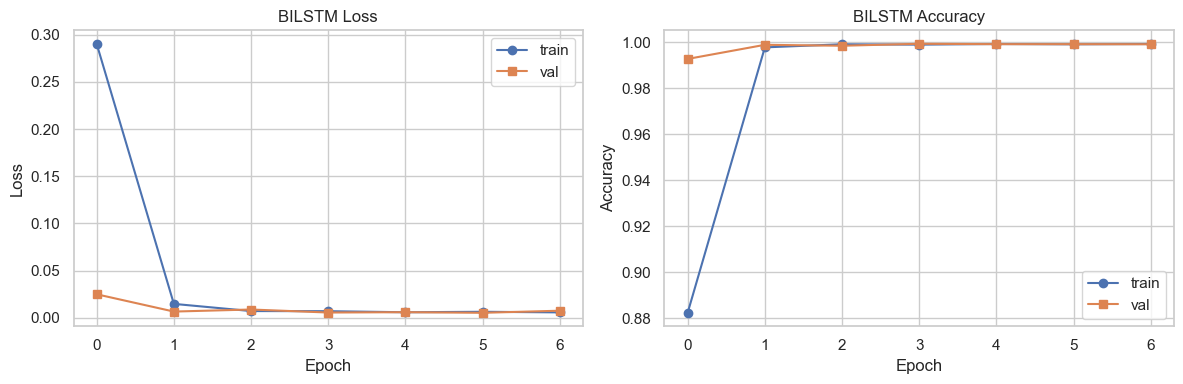

Saved c:\Users\hamza\OneDrive\Desktop\i211767_TahaHasan_A2_CS495\deep-learning-legal-clause-similarity\artifacts\bilstm_training_curves.png


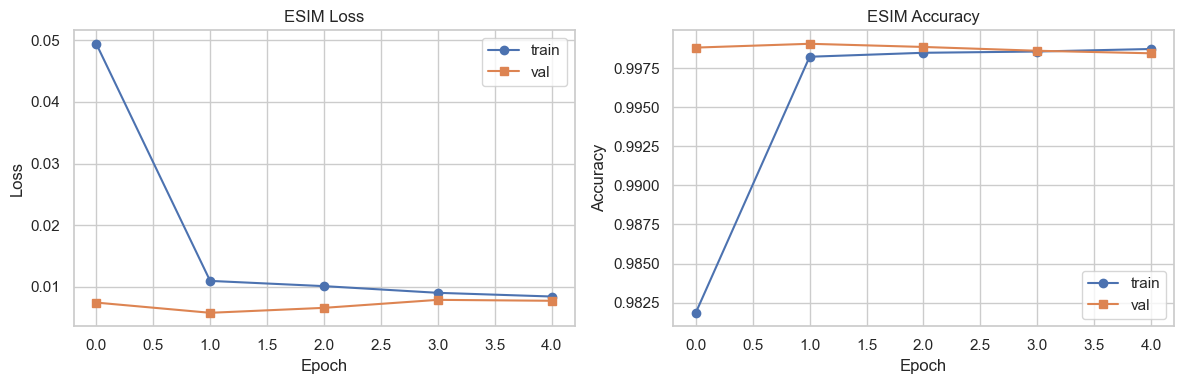

Saved c:\Users\hamza\OneDrive\Desktop\i211767_TahaHasan_A2_CS495\deep-learning-legal-clause-similarity\artifacts\esim_training_curves.png


In [81]:
# ===== TRAINING CURVES =====
def plot_training_curves(history, name):
    if not history or 'train_loss' not in history: return
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(history['train_loss'], label='train', marker='o')
    axes[0].plot(history['val_loss'], label='val', marker='s')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{name.upper()} Loss'); axes[0].legend(); axes[0].grid(True)
    axes[1].plot(history['train_acc'], label='train', marker='o')
    axes[1].plot(history['val_acc'], label='val', marker='s')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
    axes[1].set_title(f'{name.upper()} Accuracy'); axes[1].legend(); axes[1].grid(True)
    plt.tight_layout()
    out = os.path.join(ARTIFACTS, f'{name}_training_curves.png')
    plt.show()
    print(f'Saved {out}')
    plt.close()

plot_training_curves(histories['bilstm'], 'bilstm')
plot_training_curves(histories['esim'], 'esim')

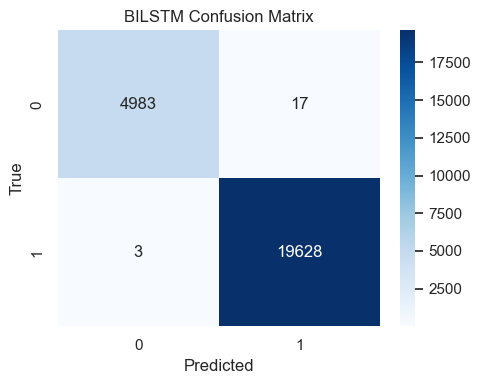

Saved c:\Users\hamza\OneDrive\Desktop\i211767_TahaHasan_A2_CS495\deep-learning-legal-clause-similarity\artifacts\bilstm_confusion_matrix.png


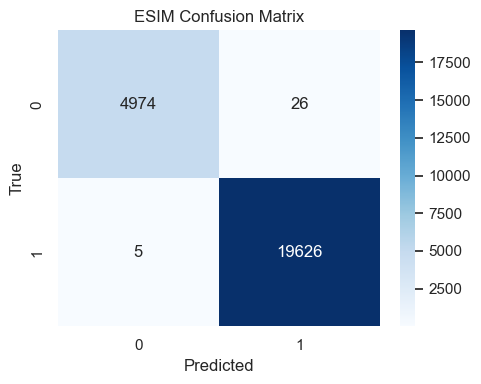

Saved c:\Users\hamza\OneDrive\Desktop\i211767_TahaHasan_A2_CS495\deep-learning-legal-clause-similarity\artifacts\esim_confusion_matrix.png


In [82]:
# ===== CONFUSION MATRICES =====
def plot_confusion(cm, name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.title(f'{name.upper()} Confusion Matrix')
    out = os.path.join(ARTIFACTS, f'{name}_confusion_matrix.png')
    plt.tight_layout()
    plt.show()
    print(f'Saved {out}')
    plt.close()

plot_confusion(np.array(metrics_bilstm['confusion_matrix']), 'bilstm')
plot_confusion(np.array(metrics_esim['confusion_matrix']), 'esim')

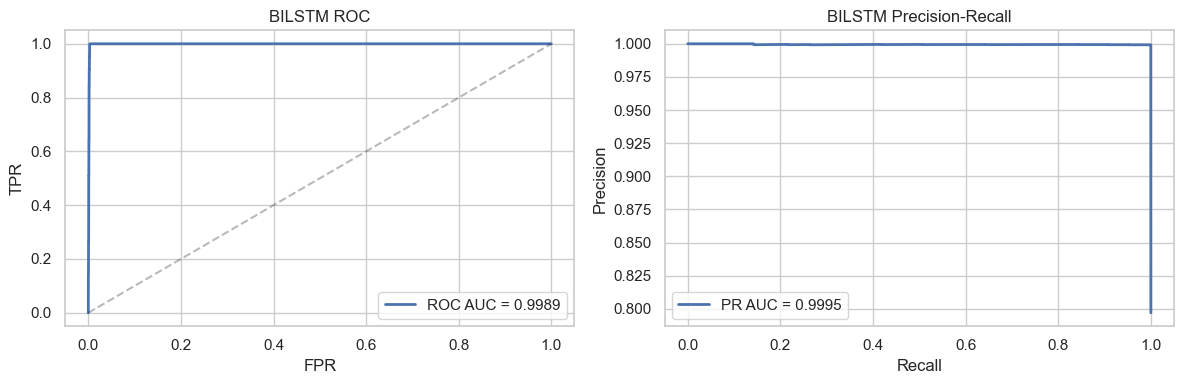

Saved c:\Users\hamza\OneDrive\Desktop\i211767_TahaHasan_A2_CS495\deep-learning-legal-clause-similarity\artifacts\bilstm_roc_pr.png


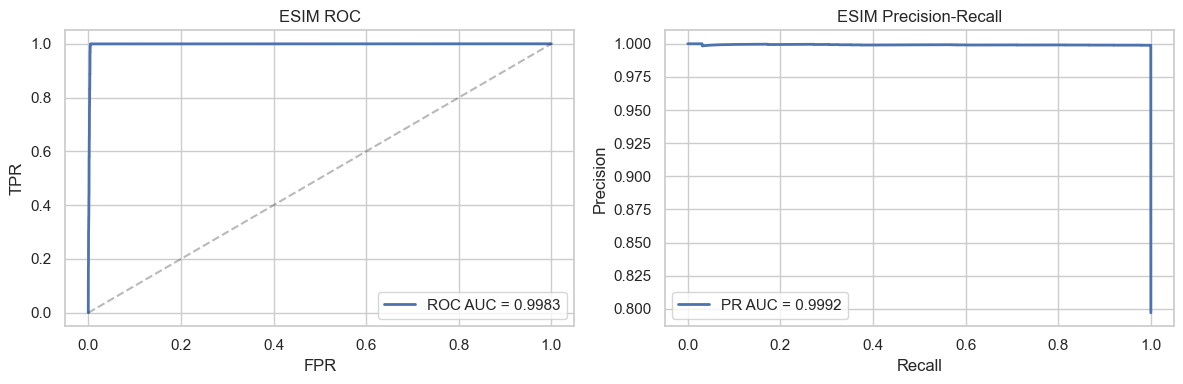

Saved c:\Users\hamza\OneDrive\Desktop\i211767_TahaHasan_A2_CS495\deep-learning-legal-clause-similarity\artifacts\esim_roc_pr.png


In [83]:
# ===== ROC & PR CURVES =====
def plot_roc_pr(metrics, name):
    fpr = np.array(metrics.get('fpr', []))
    tpr = np.array(metrics.get('tpr', []))
    precision_c = np.array(metrics.get('precision', []))
    recall_c = np.array(metrics.get('recall', []))
    if len(fpr) > 0 and len(tpr) > 0:
        roc_auc = auc(fpr, tpr)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}', linewidth=2)
        axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
        axes[0].set_xlabel('FPR'); axes[0].set_ylabel('TPR')
        axes[0].set_title(f'{name.upper()} ROC'); axes[0].legend(); axes[0].grid(True)
        if len(precision_c) > 0 and len(recall_c) > 0:
            pr_auc = auc(recall_c, precision_c)
            axes[1].plot(recall_c, precision_c, label=f'PR AUC = {pr_auc:.4f}', linewidth=2)
            axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision')
            axes[1].set_title(f'{name.upper()} Precision-Recall'); axes[1].legend(); axes[1].grid(True)
        plt.tight_layout()
        out = os.path.join(ARTIFACTS, f'{name}_roc_pr.png')
        plt.show()
        print(f'Saved {out}')
        plt.close()

plot_roc_pr(metrics_bilstm, 'bilstm')
plot_roc_pr(metrics_esim, 'esim')

In [84]:
# ===== SUMMARY TABLE =====
print('\n' + '='*80)
print('FINAL RESULTS SUMMARY')
print('='*80)
print(f'{"Model":<15} {"Acc":<10} {"Prec":<10} {"Rec":<10} {"F1":<10} {"ROC-AUC":<10} {"PR-AUC":<10}')
print('-' * 80)
print(f'{"BiLSTM":<15} {metrics_bilstm["test_acc"]:<10.4f} {metrics_bilstm["test_precision"]:<10.4f} {metrics_bilstm["test_recall"]:<10.4f} {metrics_bilstm["test_f1"]:<10.4f} {metrics_bilstm["test_roc_auc"]:<10.4f} {metrics_bilstm["test_pr_auc"]:<10.4f}')
print(f'{"ESIM":<15} {metrics_esim["test_acc"]:<10.4f} {metrics_esim["test_precision"]:<10.4f} {metrics_esim["test_recall"]:<10.4f} {metrics_esim["test_f1"]:<10.4f} {metrics_esim["test_roc_auc"]:<10.4f} {metrics_esim["test_pr_auc"]:<10.4f}')
print('='*80)
print(f'\nArtifacts saved to: {ARTIFACTS}')


FINAL RESULTS SUMMARY
Model           Acc        Prec       Rec        F1         ROC-AUC    PR-AUC    
--------------------------------------------------------------------------------
BiLSTM          0.9992     0.9991     0.9998     0.9995     0.9989     0.9995    
ESIM            0.9987     0.9987     0.9997     0.9992     0.9983     0.9992    

Artifacts saved to: c:\Users\hamza\OneDrive\Desktop\i211767_TahaHasan_A2_CS495\deep-learning-legal-clause-similarity\artifacts


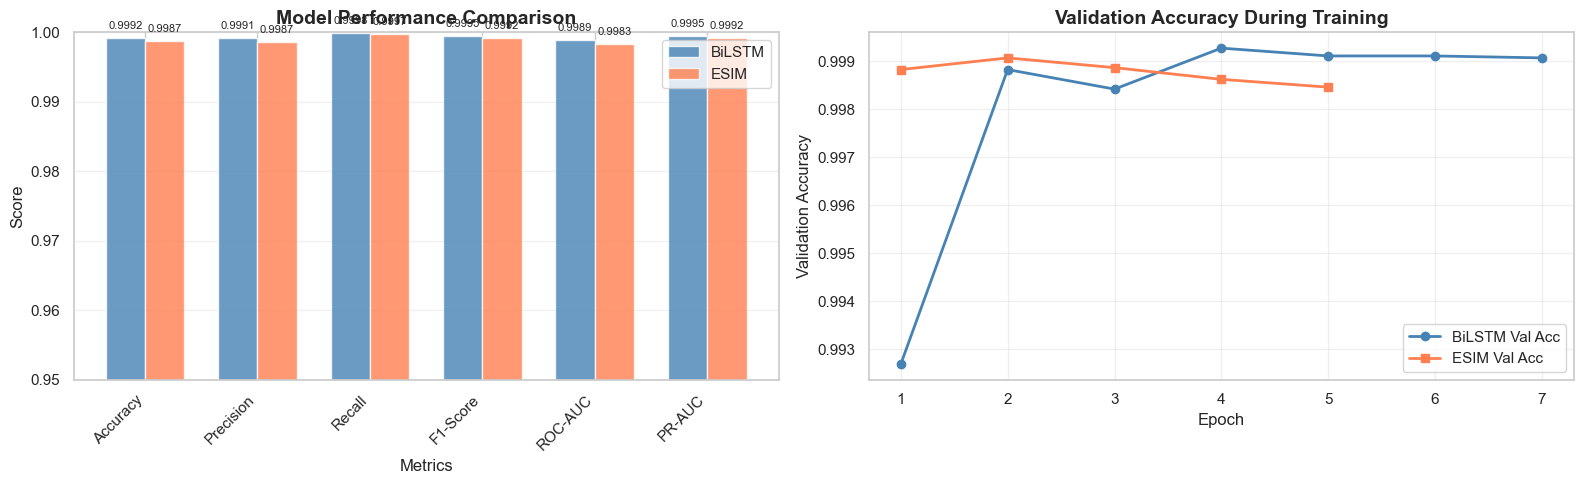


MODEL COMPARISON SUMMARY
🏆 Winner: BiLSTM (F1-Score: 0.9995 vs 0.9992)


In [85]:
# ===== COMPARISON BAR CHARTS =====
# Compare both models across all metrics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
bilstm_scores = [
    metrics_bilstm['test_acc'],
    metrics_bilstm['test_precision'],
    metrics_bilstm['test_recall'],
    metrics_bilstm['test_f1'],
    metrics_bilstm['test_roc_auc'],
    metrics_bilstm['test_pr_auc']
]
esim_scores = [
    metrics_esim['test_acc'],
    metrics_esim['test_precision'],
    metrics_esim['test_recall'],
    metrics_esim['test_f1'],
    metrics_esim['test_roc_auc'],
    metrics_esim['test_pr_auc']
]

x = np.arange(len(metrics_names))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar chart comparison
axes[0].bar(x - width/2, bilstm_scores, width, label='BiLSTM', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, esim_scores, width, label='ESIM', color='coral', alpha=0.8)
axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.95, 1.0])

# Add value labels on bars
for i, (b_score, e_score) in enumerate(zip(bilstm_scores, esim_scores)):
    axes[0].text(i - width/2, b_score + 0.001, f'{b_score:.4f}', ha='center', va='bottom', fontsize=8)
    axes[0].text(i + width/2, e_score + 0.001, f'{e_score:.4f}', ha='center', va='bottom', fontsize=8)

# Training curves comparison
if len(histories['bilstm']['train_loss']) > 0 and len(histories['esim']['train_loss']) > 0:
    epochs_bilstm = range(1, len(histories['bilstm']['train_loss']) + 1)
    epochs_esim = range(1, len(histories['esim']['train_loss']) + 1)
    
    axes[1].plot(epochs_bilstm, histories['bilstm']['val_acc'], marker='o', label='BiLSTM Val Acc', color='steelblue', linewidth=2)
    axes[1].plot(epochs_esim, histories['esim']['val_acc'], marker='s', label='ESIM Val Acc', color='coral', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Validation Accuracy', fontsize=12)
    axes[1].set_title('Validation Accuracy During Training', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Training histories not available\n(models loaded from checkpoint)', 
                 ha='center', va='center', fontsize=12, transform=axes[1].transAxes)
    axes[1].set_title('Training History', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print winner
print('\n' + '='*80)
print('MODEL COMPARISON SUMMARY')
print('='*80)
if metrics_bilstm['test_f1'] > metrics_esim['test_f1']:
    print(f"🏆 Winner: BiLSTM (F1-Score: {metrics_bilstm['test_f1']:.4f} vs {metrics_esim['test_f1']:.4f})")
else:
    print(f"🏆 Winner: ESIM (F1-Score: {metrics_esim['test_f1']:.4f} vs {metrics_bilstm['test_f1']:.4f})")
print('='*80)